In [2]:
import numpy as np 
import awkward as ak
import sys
sys.path.append("..")
from binary_decoders import lecroy
from oscilliscope_fitting import mcp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import fft, ifft
import importlib

0.10000004117581432


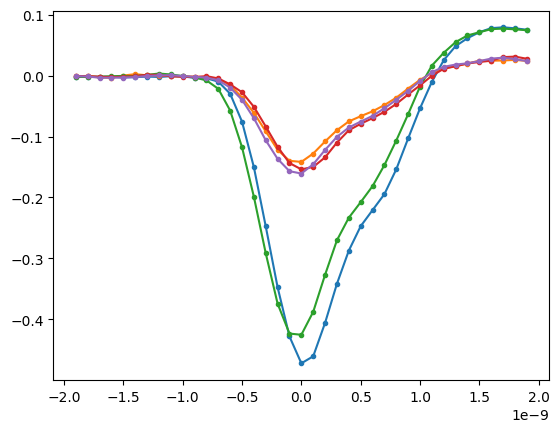

In [ ]:
mcp_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C2--Trace5100.trc")

#plt.scatter(mcp_data.x[5], mcp_data.y[5], s=1)

# https://psec.uchicago.edu/blogs/lappd/wp-content/uploads/2008/08/Analytic_function.pdf
A = 1 + 10**(-4)
t0 = 1 * 10**(-9)
tau = 330*10**(-12)
AMP = 1.2*10**6

def h(t):
    return np.where(t > 0, (t / tau) * np.exp(-t / tau), 0)

def f(t):
    return np.where((t > 0) & (t < t0), A*((A/(A - 1))**(-t/t0)) - A, 0)

def g(t):
    dt = t[1] - t[0] # assuming constant sampling rate
    return ifft( fft(f(t)) * fft(h(t)) * dt)  * len(t)

ts = np.arange(-1,15,0.01)*10**(-9)
#plt.plot(ts + 2.48*10**-7, AMP*g(ts).real)


for i in range(5,10):
    # Extract the x and y data
    t_data = mcp_data.x[i]
    y_data = mcp_data.y[i]
    #plt.scatter(t_data[mask], y_data[mask], s=4)
    peak_time = t_data[np.argmin(y_data)]
    t_data = t_data - peak_time
    mask = (t_data > -0.002*10**(-6)) & (t_data < 0.002*10**(-6))
    plt.plot(t_data[mask], y_data[mask], marker='.')

print((t_data[1] - t_data[0])*10**9) # 0.1ns 

# find max and shift by that much time for the fit


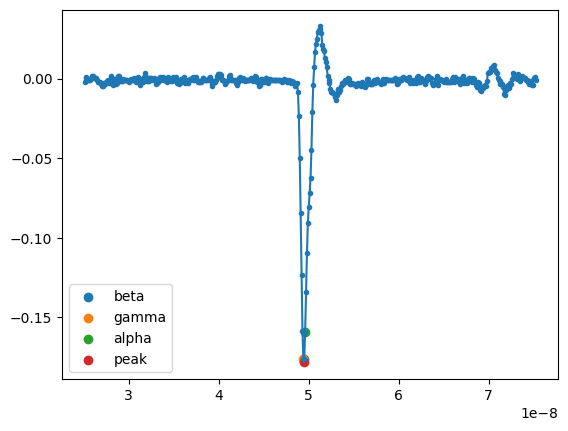

In [ ]:
def argnsmall(arr, n: int) -> float:
    return np.argpartition(arr, n)[n]

# interpolation fit method (columnar)
mcp_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C2--Trace5100.trc")
x = mcp_data.x[1]
y = mcp_data.y[1]

smallest_idxs = np.argpartition(y, 3)[:3]

peak_xs = x[smallest_idxs]
peak_ys = y[smallest_idxs]

def calc_parabola(x1,y1,x2,y2,x3,y3):
    matrix = np.array([
        [x1**2, x1, 1],
        [x2**2, x2, 1],
        [x3**2, x3, 1]
    ])
    inv_matrix = np.linalg.inv(matrix)
    y = np.array([y1, y2, y3])
    return inv_matrix @ y

A, B, C = calc_parabola(peak_xs[0], peak_ys[0], 
                        peak_xs[1], peak_ys[1], 
                        peak_xs[2], peak_ys[2])

peak = C - B**2 / (4*A)

plt.scatter(peak_xs[0], peak_ys[0], label="beta")
plt.scatter(peak_xs[1], peak_ys[1], label="gamma")
plt.scatter(peak_xs[2], peak_ys[2], label="alpha")
plt.scatter(-B/(2*A), peak, label="peak")

#mask = (x<0e-8) & (x>-0.15e-8)
#plt.plot(x[mask],y[mask], marker='.')
# plt.plot(x,y, marker='.')

plt.legend()

[1.12783868 4.99879354]
4.998793516542644 4.9987935728217945
-7.262407476337439e-10


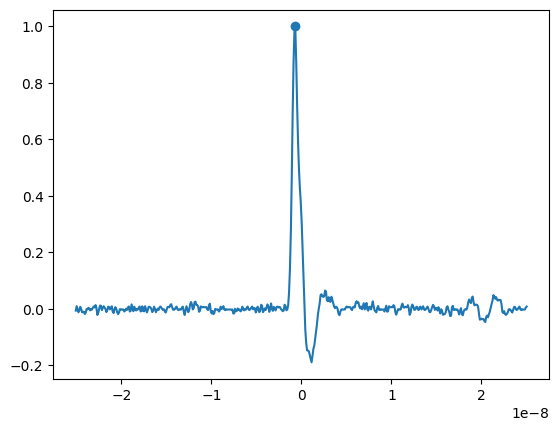

In [ ]:
importlib.reload(mcp)
mcp_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C2--Trace5100.trc")
x = mcp_data.x
y = mcp_data.y + 5

x_peaks, y_peaks = mcp.interpolate_mcp_peak(x, y)

# calc baseline (x_peaks, y_peaks) -> or where you want to chop!
pulse_window_estimate = 1e-8
# 3. Remove all points around peak
x_peaks_expanded = x_peaks[:, np.newaxis]

window_mask = (x < (x_peaks_expanded - pulse_window_estimate)) | (x > (x_peaks_expanded + pulse_window_estimate))
base_x = np.where(window_mask, x, np.NaN)
base_y = np.where(window_mask, y, np.NaN)

baseline_idxs = np.isfinite(base_x) & np.isfinite(base_y)
baseline = np.polyfit(base_x[baseline_idxs], base_y[baseline_idxs], 1)

m, b = baseline
ts = np.arange(-2.5,2.5,0.01)*1e-8

fit_ys = m*ts + b

# scale mcp signal between 0 and  1
v_mins = np.ones_like(y_peaks)[:,np.newaxis] * b
v_maxs = y_peaks[:,np.newaxis] #have to do [:,np.newaxis], just takes the array and wrapps arrays around each peak (float)
volts_scaled = (y - v_mins) / (v_maxs-v_mins)

#mask = (x<0e-8) & (x>-0.1e-8)
plt.plot(x[0], volts_scaled[0])
plt.scatter(x_peaks[0], 1, label="peak")
print(x_peaks[0])


[5.00381288 5.00368603 5.00355707 5.00343478 5.00333104 5.0032503
 5.00319748 5.00318804 5.00324187 5.00337161 5.00358331 5.00387768
 5.00424181 5.00465283 5.00509089 5.00553778 5.00598174 5.00641497
 5.00682617 5.00720442 5.00753758 5.00781848 5.00804835 5.00823333
 5.00839046 5.0085391  5.00867671 5.0087864  5.00885058 5.00886163
 5.00882122 5.00872562 5.00857401 5.00837369 5.00813561 5.00786976
 5.00757477 5.00724443 5.00688025 5.0064909  5.00608437 5.0056731
 5.00527949 5.00491909 5.00459551 5.004314   5.00408863 5.00393703
 5.00386885 5.00387932 5.0039545  5.00408335 5.00425741 5.00446882
 5.00471154 5.00498061 5.00526498 5.00555093 5.00582804 5.00608483
 5.00631642 5.00652754 5.00671535 5.00687102 5.00699467 5.00709048
 5.00715515 5.00719347 5.00721172 5.00721108 5.00719286 5.0071565
 5.00710643 5.00705581 5.00700959 5.00696605 5.00693269 5.0069106
 5.00689307 5.00688308 5.00688414 5.0068884  5.0068851  5.00687147
 5.0068523  5.00683863 5.00684205 5.00686392 5.00690188 5.00696187

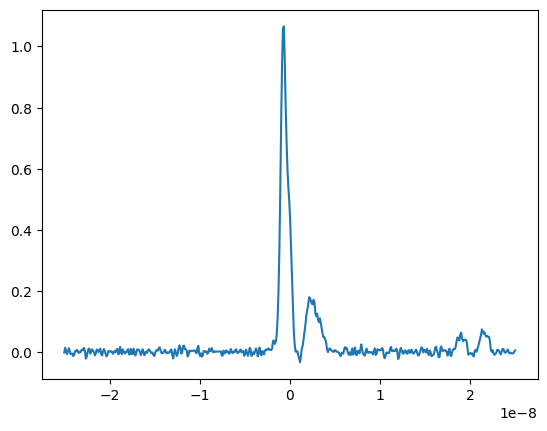

In [108]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

from scipy.sparse import diags, eye
from scipy.linalg import cholesky

def baseline(y, lam, ratio):
    N = len(y)
    D = diags([1, -2, 1], [0, 1, 2], shape=(N-2, N)).toarray()
    H = lam * (D.T @ D)
    w = np.ones(N)
    
    while True:
        W = diags(w, 0, shape=(N, N)).toarray()
        C = cholesky(W + H, lower=True)
        z = np.linalg.solve(C.T, np.linalg.solve(C, w * y))
        d = y - z
        dn = d[d < 0]
        
        m = np.mean(dn)
        s = np.std(dn)
        
        wt = 1 / (1 + np.exp(2 * (d - (2*s - m)) / s))
        
        if np.linalg.norm(w - wt) / np.linalg.norm(w) < ratio:
            break
        w = wt

    return z

# 0.001 ≤ p ≤ 0.1 is a good choice (for a signal with positive peaks) and 10^2 ≤ λ ≤ 10^9 
z = baseline(volts_scaled[0]+5, 1e3, 1e-4)
print(z)
plt.plot(x[0], volts_scaled[0]+5 - z)

In [115]:
mcp_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C2--Trace5100.trc")
x = mcp_data.x
y = mcp_data.y

print(x[0,-1] - x[0,0])

5.010002062907432e-08


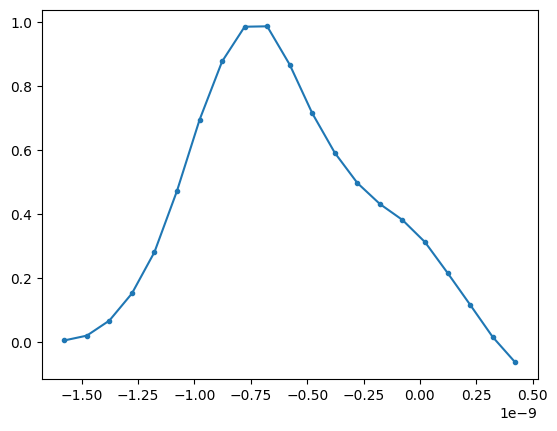

In [83]:
importlib.reload(mcp)
mcp_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C2--Trace5100.trc")
x = mcp_data.x
y = mcp_data.y

seconds, volts = mcp.MCPSignalScaler.normalize(x,y)

s, v = seconds[0], volts[0]

mask = (s < 0.05e-8) & (s > -0.16e-8)
plt.plot(s[mask], v[mask], marker='.')

# fit high order polynomial

[-0.00448317 -0.00067013 -0.00456464  0.00085536  0.00883065]
0.0005117004479973273 0.9999999999999998
0.00019102629499324002
tg_20=-1.2369472571989883


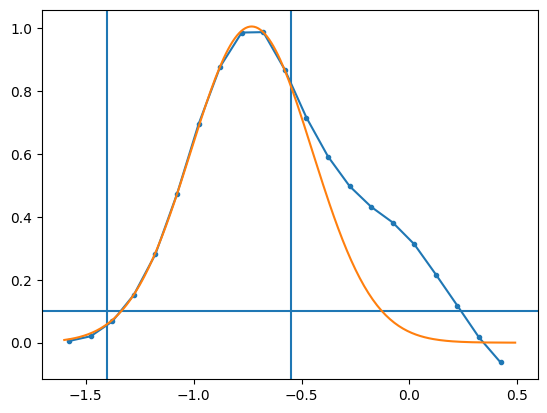

In [174]:
# fit guass
gaus = lambda x, N, mu, sigma: N*np.exp(-(x-mu)**2/(2.0*sigma**2))

s, v = seconds[0], volts[0]

nano_s = s*10**9
fit_stop = -0.55
fit_start = -1.4
mask = (nano_s < fit_stop) & (nano_s > fit_start)
plt.axvline(fit_stop)
plt.axvline(fit_start)
plt.axhline(0.1)
popt, pcov = curve_fit(
    gaus, 
    nano_s[mask], 
    v[mask], 
    p0=[1, np.mean(nano_s), 0.1]
)
r = v[mask] - gaus(nano_s[mask], *popt)
print(r[:5])
from scipy.stats import chisquare
def chi2(n, y):
    return chisquare(n, np.sum(n)/np.sum(y) * y)

obs = v[mask]
exp = gaus(nano_s[mask], *popt)
chi2_stat, p_value = chi2(obs, exp)
print(chi2_stat, p_value)

fit_area = (obs < 0.8) & (obs > 0.1)
obs = obs[fit_area]
exp = exp[fit_area]
chi_square_test_statistic2  = np.sum(
    np.square(obs - exp) / exp
)
print(chi_square_test_statistic2)

mask2 = (nano_s < 0.5) & (nano_s > -1.6)
plt.plot(nano_s[mask2], v[mask2], marker='.')

nts = np.arange(-1.6, 0.5, 0.01)
plt.plot(nts, gaus(nts, *popt))

tg_20 = popt[1] - np.sqrt(2*popt[2]**2*np.log(popt[0]/0.2))
print(f"{tg_20=}")

[ 6.93919930e-04 -7.45956926e-06 -4.14114087e-03  5.52898074e-03
 -2.07430022e-03]
Power_divergenceResult(statistic=0.00013887156243520832, pvalue=0.9999999975894477)
t_20=-1.2372616856944596
tg_20=-1.2369472571989883
0.00031442849547125284


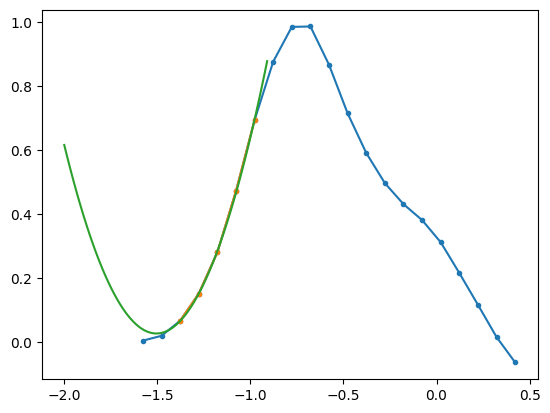

In [176]:
s, v = seconds[0], volts[0]

nano_s = s*10**9
mask2 = (nano_s < 0.5) & (nano_s > -1.6)
plt.plot(nano_s[mask2], v[mask2], marker='.')

point_select = (v>0.05) & (v<0.8)
nano_s_points = nano_s[point_select][:5]
v_points = v[point_select][:5]
plt.plot(nano_s_points, v_points, marker='.')

A, B, C = np.polyfit(nano_s_points, v_points, 2)

ts = np.arange(-2, -0.9, 0.01)
fit_exp = A*ts**2 + B*ts + C
plt.plot(ts, fit_exp)

residuals = v_points - (A*nano_s_points**2 + B*nano_s_points + C)
print(residuals)

print(chi2(v_points, A*nano_s_points**2 + B*nano_s_points + C))


t_20 = (-B + np.sqrt(B**2 - 4*A*(C-0.2))) / (2*A)
print(f"{t_20=}")
print(f"{tg_20=}")
print(f"{tg_20 - t_20}")

-1.2369472564274535
-1.3075510911447754


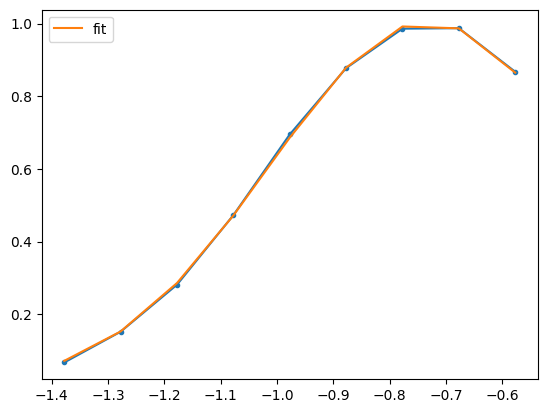

In [185]:
# gaussian fit routine!
importlib.reload(mcp)
mcp_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C2--Trace5100.trc")
x = mcp_data.x
y = mcp_data.y

seconds, volts = mcp.MCPSignalScaler.normalize(x,y)

def gauss_timestamp(x, y, threshold=0.2, show_plot=False):
    gaus = lambda x, N, mu, sigma: N*np.exp(-(x-mu)**2/(2.0*sigma**2))
    popt, _ = curve_fit(
        gaus, 
        x, 
        y, 
        p0=[1, x[np.argmax(y)], 0.1]
    )
    N, mu, sigma = popt
    timestamp = mu - np.sqrt(2*sigma**2*np.log(N/threshold))

    if show_plot:
        plt.plot(x, y, marker='.')
        plt.plot(x, gaus(x, *popt), label='fit')
        plt.legend()
    return timestamp

fit_stop = -0.55e-9
fit_start = -1.4e-9
mask = (seconds[0] < fit_stop) & (seconds[0] > fit_start)
print(gauss_timestamp(seconds[0][mask]*1e9, volts[0][mask], show_plot=True))

timestamps = [gauss_timestamp(s*1e9, v) for s,v in zip(seconds,volts)]

In [ ]:
# parabola fit

point_select = (v>0.05) & (v<0.8)
nano_s_points = nano_s[point_select][:5]

